<a href="https://colab.research.google.com/github/aishwarya756/Bayesian-CNN/blob/main/Bayesian_CNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bayesian Convolutional Neural Networks
Tensorflow and Tensorflow-Probability implementation of Bayesian covnolutional neural networks for classification of MNIST dataset. The model will only predict when it is confident enough.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 2.3.0
TensorFlow Probability version: 0.11.0


Loading MNIST dataset
11493376/11490434 [==============================] - 0s 0us/step
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


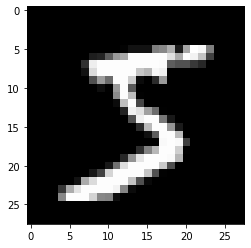

In [2]:
#Load MNIST dataset
n_class = 10

batch_size = 128
n_epochs = 20
lr = 1e-3

print('Loading MNIST dataset')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[0, :, :, 0], cmap='gist_gray')
plt.show()

In [19]:
#Define the kernel divergence function that comes with a weight
def get_kernel_divergence_fn(train_size, w=1.0):
    
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [4]:
# Add a variable "weight" to the layer
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

In [5]:
#Define the loss function of negative log-likelihood (input as logits)
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

In [6]:
#Build and train the Bayesian CNN model
def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(10, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], n_train)
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'],
                   experimental_run_tf_function=False)
bcnn_model.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 14, 14, 32)        609       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 7, 7, 64)          36929     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_______________________________________________

In [7]:
hist = bcnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_split=0.1)

Epoch 1/20
422/422 [==============================] - 105s 249ms/step - loss: 67.5207 - acc: 0.8402 - val_loss: 64.7879 - val_acc: 0.9172
Epoch 2/20
422/422 [==============================] - 105s 248ms/step - loss: 61.9711 - acc: 0.9403 - val_loss: 58.9908 - val_acc: 0.9637
Epoch 3/20
422/422 [==============================] - 110s 260ms/step - loss: 55.9052 - acc: 0.9588 - val_loss: 52.7000 - val_acc: 0.9702
Epoch 4/20
422/422 [==============================] - 105s 249ms/step - loss: 49.4660 - acc: 0.9670 - val_loss: 46.1851 - val_acc: 0.9752
Epoch 5/20
422/422 [==============================] - 105s 248ms/step - loss: 42.9649 - acc: 0.9726 - val_loss: 39.7691 - val_acc: 0.9738
Epoch 6/20
422/422 [==============================] - 105s 248ms/step - loss: 36.6717 - acc: 0.9757 - val_loss: 33.6580 - val_acc: 0.9757
Epoch 7/20
422/422 [==============================] - 104s 247ms/step - loss: 30.8411 - acc: 0.9761 - val_loss: 28.1468 - val_acc: 0.9780
Epoch 8/20
422/422 [==============

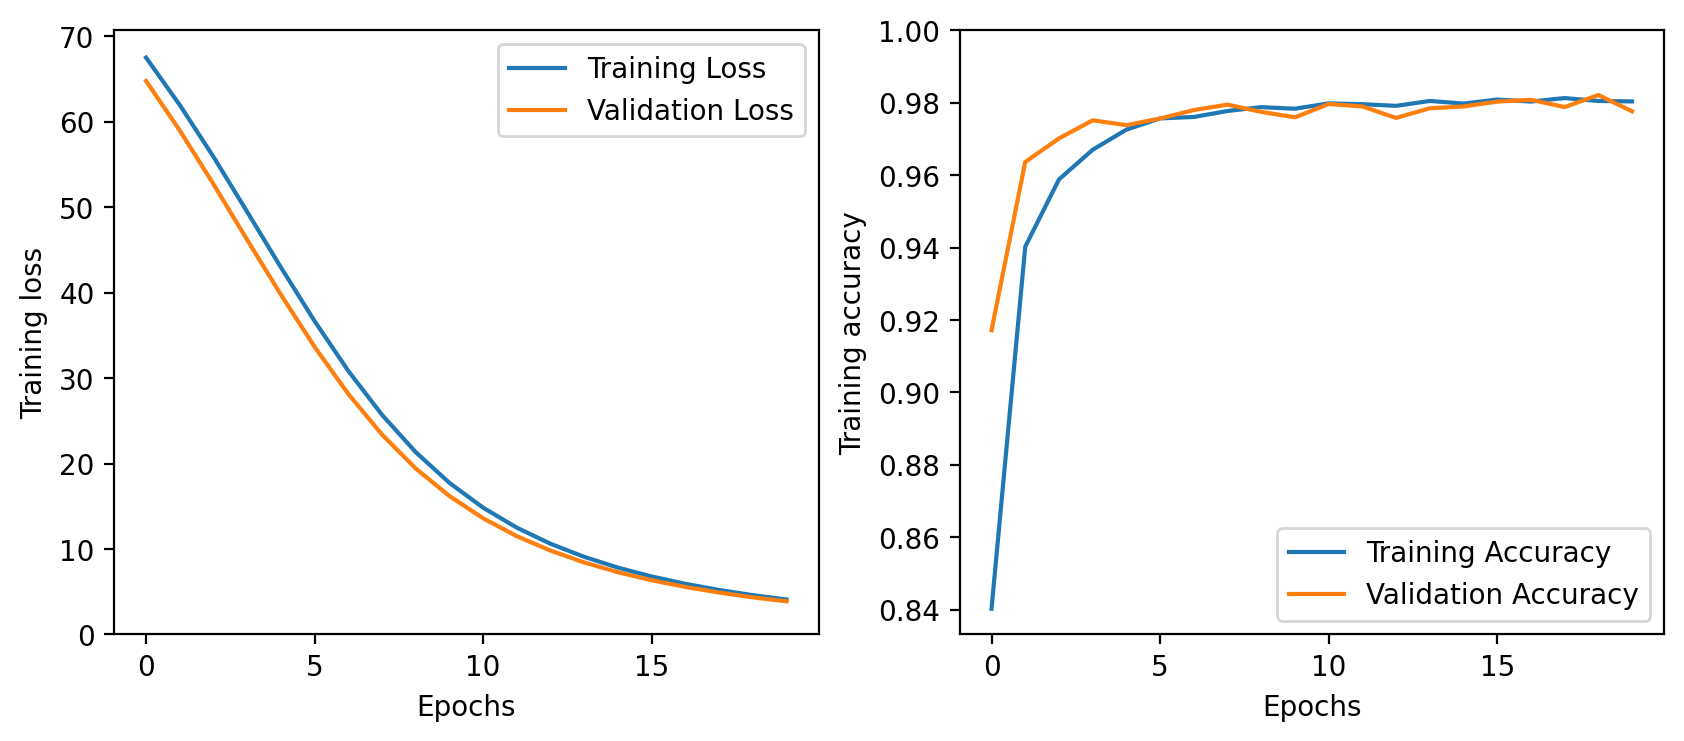

In [8]:
#Plot training process
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

ax[0].plot(range(n_epochs), hist.history['loss'], label='Training Loss')
ax[0].plot(range(n_epochs), hist.history['val_loss'], label='Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[0].set_ylim([0, None])

ax[1].plot(range(n_epochs), hist.history['acc'], label='Training Accuracy')
ax[1].plot(range(n_epochs), hist.history['val_acc'], label="Validation Accuracy")
ax[1].legend()
ax[1].set_ylim([None, 1])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training accuracy')

plt.show()

In [10]:
#Quantify the uncertainty in predictions through sampling
n_mc_run = 100

y_pred_logits_list = np.array([bcnn_model.predict(X_test) for _ in range(n_mc_run)])  # a list of predicted logits

In [11]:
print(X_test.shape)
print(y_pred_logits_list.shape)

print('\ntest sample 0, label = 0, samples:\n', y_pred_logits_list[:10,0,0])
print('\ntest sample 0, label = 7, samples:\n', y_pred_logits_list[:10,0,7])

(10000, 28, 28, 1)
(100, 10000, 10)

test sample 0, label = 0, samples:
 [ -8.019832   -6.3151937  -4.89449   -13.092649   -1.2088196 -12.3485155
  -4.9543023  -6.3937306  -8.345824   -5.225159 ]

test sample 0, label = 7, samples:
 [17.085566 15.796733 23.176617 20.456097 20.996613 18.642284 24.18916
 15.455267 18.919407 19.913746]


In [12]:
med_prob_thres = 0.2 # probability threshold
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = np.array([np.array([int(np.median(y) >= med_prob_thres) for y in y_pred_prob]) for y_pred_prob in y_pred_prob_all])

In [13]:
idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9995
Unrecognizable samples: [2293 3906 4265 4761 9679]
Test accuracy on MNIST (recognizable samples): 0.9864932466233116
Test accuracy on MNIST (unrecognizable samples): 0.0


In [14]:
#Define the function that plots the histogram of predicted probabilities across all possible classes
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(20, 7)):
    print('\nmedian of predicted probs = \n', np.median(y_pred, axis=1))
    bins = np.logspace(-n_bins, 0, n_bins+1)
    n_subplot_cols = (n_class + 1) // n_subplot_rows
    fig, ax = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=figsize, dpi=150)
    for i in range(n_subplot_rows):
        for j in range(n_subplot_cols):
            idx = i * n_subplot_cols + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    fig.subplots_adjust(hspace=0.4)
    plt.show()

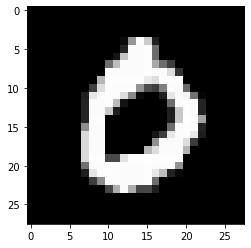

True label of the test sample 3: 0

median of predicted probs = 
 [9.9998760e-01 5.4792788e-09 6.1085586e-07 4.3779078e-09 5.6481246e-09
 3.6097823e-09 5.5793357e-06 7.7521236e-08 1.2746762e-08 4.2226041e-08]


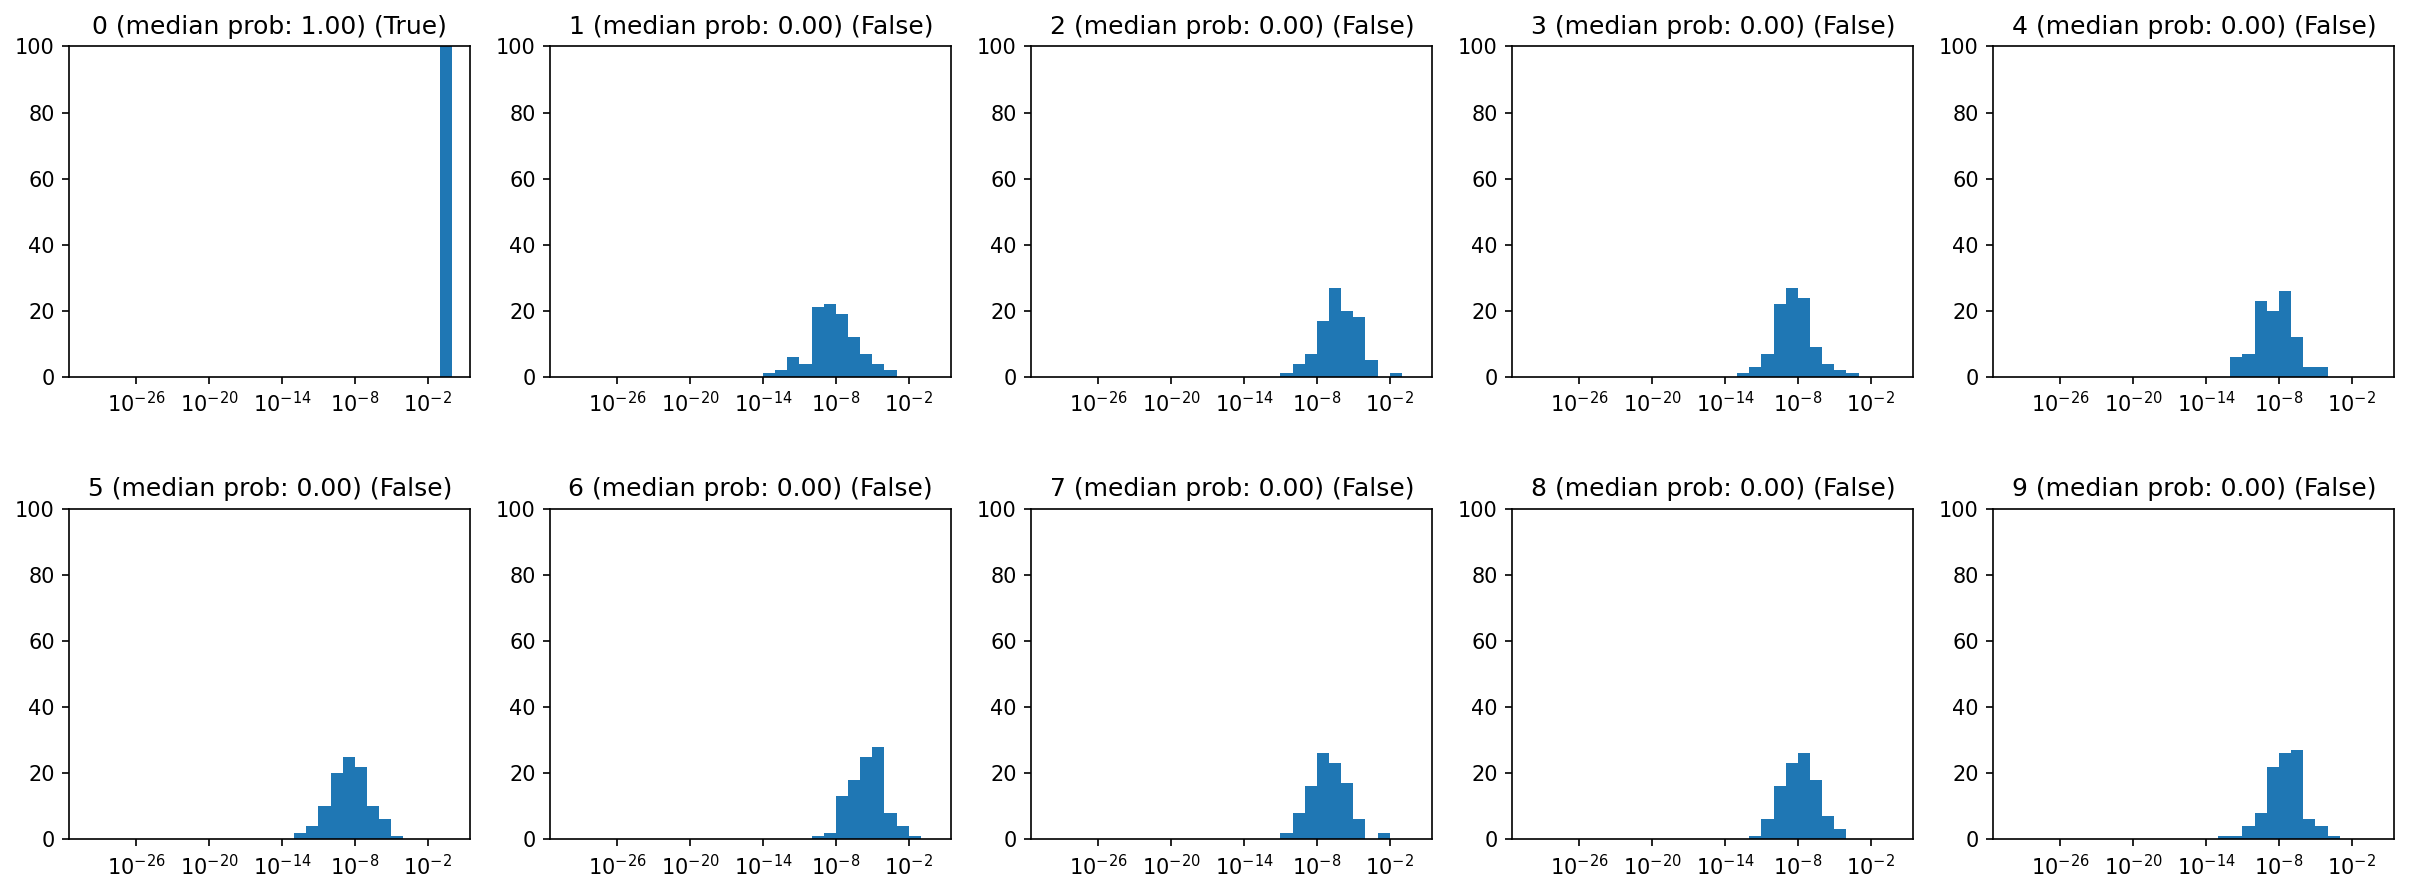

Predicted label of the test sample 3: 0


In [15]:
# a recognizable example
idx = 3
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
plt.show()
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

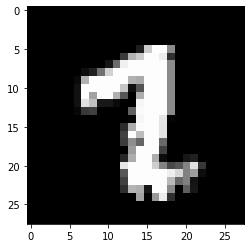

True label of the test sample 659: 2

median of predicted probs = 
 [2.0554135e-06 7.7611417e-02 5.7172388e-02 8.7316744e-03 5.4548391e-06
 4.0536765e-06 6.1278109e-07 6.5091705e-01 7.9841912e-03 1.7185585e-04]


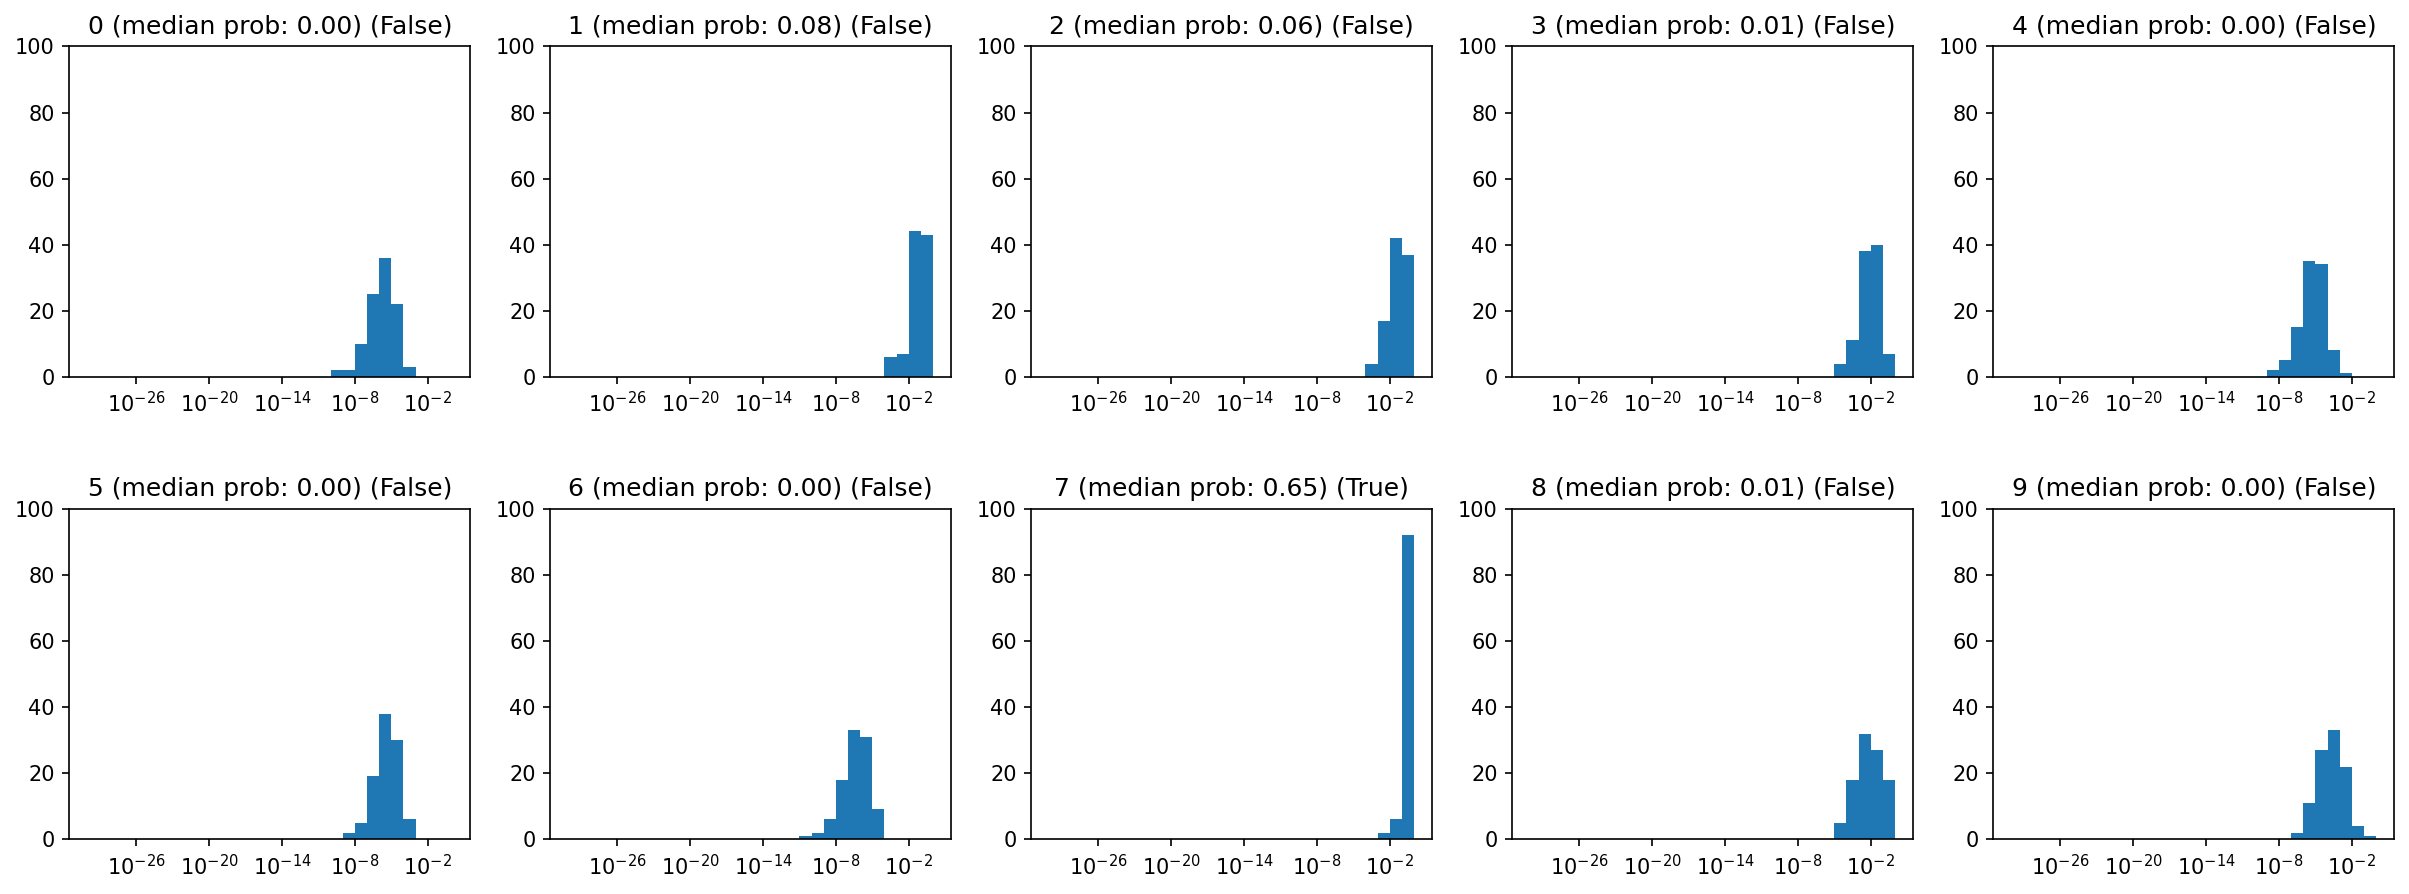

Predicted label of the test sample 659: 7


In [16]:
#an unrecognized example
idx = 659
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
plt.show()
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

In [17]:
#Predict non-number images in Fashion-MNIST dataset
print('Loading Fashion-MNIST dataset')
_, (X_f_test, y_f_test) = tf.keras.datasets.fashion_mnist.load_data()

X_f_test = np.expand_dims(X_f_test, -1)[:1000]
y_f_test = tf.keras.utils.to_categorical(y_f_test, n_class)[:1000]

print("X_f_test.shape =", X_f_test.shape)
print("y_f_test.shape =", y_f_test.shape)

Loading Fashion-MNIST dataset
4423680/4422102 [==============================] - 0s 0us/step
X_f_test.shape = (1000, 28, 28, 1)
y_f_test.shape = (1000, 10)


In [18]:
#Quantify uncertainty
n_mc_run = 100

y_f_pred_logits_list = np.array([bcnn_model.predict(X_f_test) for _ in range(n_mc_run)])  # a list of predicted logits

In [20]:
print(X_f_test.shape)
print(y_f_pred_logits_list.shape)

print('\ntest sample 0, label = 0, samples:\n', y_f_pred_logits_list[:10,0,0])
print('\ntest sample 0, label = 7, samples:\n', y_f_pred_logits_list[:10,0,7])

(1000, 28, 28, 1)
(100, 1000, 10)

test sample 0, label = 0, samples:
 [ 4727.206  -5569.8203 -1405.0671  -534.6798   335.0261 -2542.971
 -4238.975  -5018.1567 -2929.3896 -1251.8721]

test sample 0, label = 7, samples:
 [  722.75073 -1253.0188  -2760.07    -1987.6539    596.54193 -2978.055
 -3941.1335   -487.68802  -742.19415 -1456.9417 ]


In [21]:
med_prob_thres = 0.2 # probability threshold
y_f_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_f_pred_logits_list], axis=-1)
y_f_pred = np.array([np.array([int(np.median(y) >= med_prob_thres) for y in y_f_pred_prob]) for y_f_pred_prob in y_f_pred_prob_all])

In [22]:
idx_f_valid = [any(y) for y in y_f_pred]
print('Number of recognizable samples:', sum(idx_f_valid))
# print('Recognizable samples:', np.where(idx_f_valid)[0])

idx_f_invalid = [not any(y) for y in y_f_pred]
print('Number of unrecognizable samples:', sum(idx_f_invalid))
print('\n10 unrecognizable samples:', np.where(idx_f_invalid)[0][:10])

print('\nTest accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_f_test[idx_f_valid], axis=-1), np.argmax(y_f_pred[idx_f_valid], axis=-1))) / len(y_f_test[idx_f_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_f_test[idx_f_invalid], axis=-1), np.argmax(y_f_pred[idx_f_invalid], axis=-1))) / len(y_f_test[idx_f_invalid]))

Number of recognizable samples: 147
Number of unrecognizable samples: 853

10 unrecognizable samples: [ 1  2  3  4  5  6  7  9 10 13]

Test accuracy on MNIST (recognizable samples): 0.006802721088435374
Test accuracy on MNIST (unrecognizable samples): 0.123094958968347


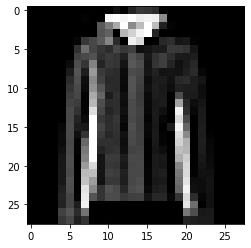

True label of the test sample 6: 4

median of predicted probs = 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


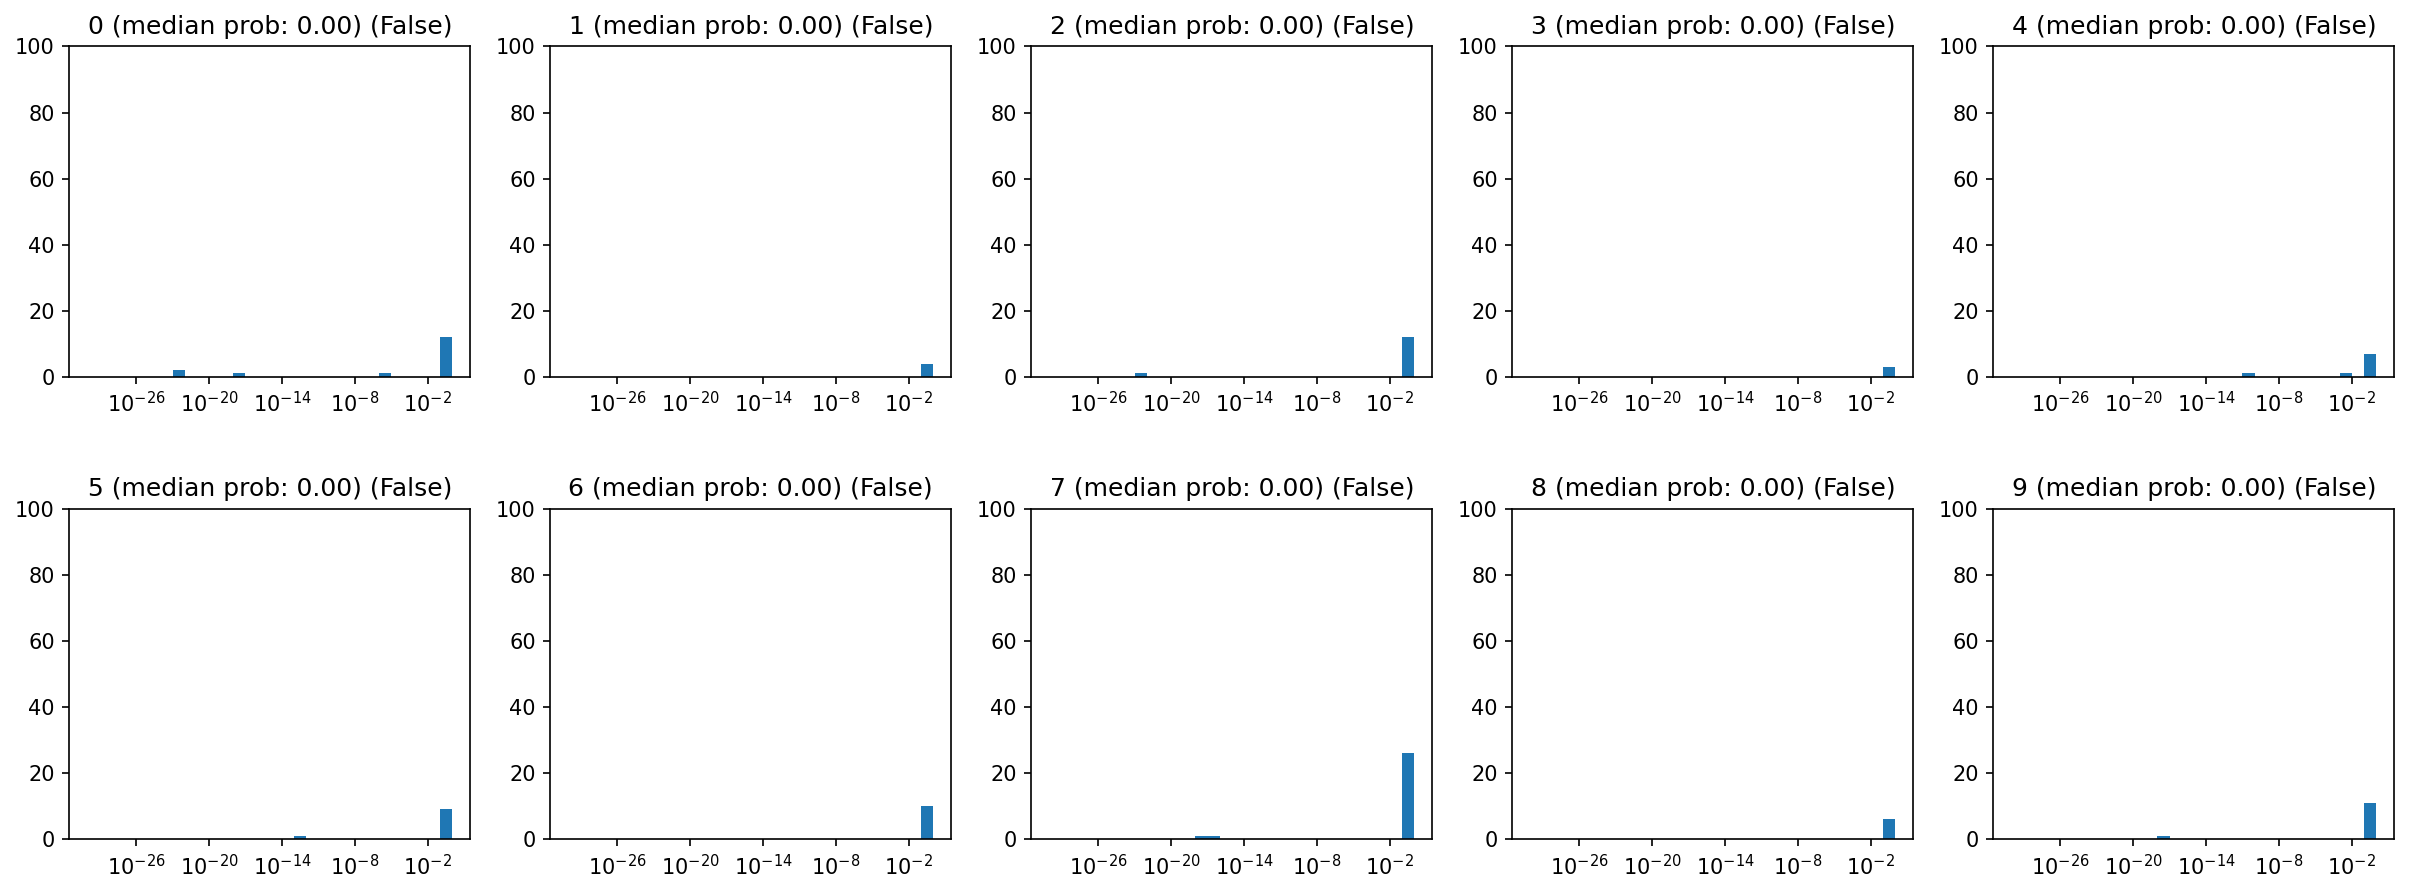

I don't know!


In [23]:
#An unrecognizable example
idx = 6
plt.imshow(X_f_test[idx, :, :, 0], cmap='gist_gray')
plt.show()
print("True label of the test sample {}: {}".format(idx, np.argmax(y_f_test[idx], axis=-1)))

plot_pred_hist(y_f_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_f_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")